In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import transformers

sys.path.append('../')
from multimeter_analysis import *

/storage/vsub851/anaconda3/envs/multi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
start_index = 25
end_index = 28

## Weight Magnitude Analysis

In [26]:
def get_avg_magnitude(leaf_modules, start_idx, end_idx):
    avg_magnitudes = []
    for i in range(start_index, end_index):
        module = leaf_modules[i]
        weights = get_module_weights(module)
        if not weights:
            continue
        avg_magnitude = calculate_average_magnitude(weights)
        avg_magnitudes.append(avg_magnitude)
    return np.mean(avg_magnitudes)

In [27]:
og_model_path = os.path.join('..', 'language_modeling', 'sparse-gpt2-wikitext', 'checkpoint-20000')
model = transformers.AutoModel.from_pretrained(og_model_path)

In [28]:
leaf_modules = get_leaf_modules(model)

In [29]:
og_magnitude = get_avg_magnitude(leaf_modules, start_index, end_index)

In [60]:
multimeter_base = os.path.join('..', 'language_modeling', 'sparse_init-gpt2-wikitext-multi-pos')
multimeter_paths = [os.path.join(multimeter_base, f'checkpoint-{i+1}0000', 'original_network') for i in range(4)]
multimeter_magnitudes = []
for path in multimeter_paths:
    mul_model = transformers.AutoModel.from_pretrained(path)
    mul_leaf_modules = get_leaf_modules(mul_model, leaf_modules = [])
    mul_mag = get_avg_magnitude(mul_leaf_modules, start_index, end_index)
    multimeter_magnitudes.append(mul_mag)
multimeter_magnitudes += [np.exp(-14.9801), np.exp(-17.834), np.exp(-18.2311)]
print(multimeter_magnitudes)

[2.0661034341173945e-06, 2.268462822030415e-06, 1.1799058938777307e-06, 4.807016011909582e-07, 3.120507506578852e-07, 1.7980104426398063e-08, 1.2087427187137882e-08]


In [61]:
multimeter_steps = [0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000]
weight_mag = [og_magnitude] + multimeter_magnitudes
print(np.log(weight_mag))

[-13.76976639 -13.08984612 -12.99640813 -13.65007587 -14.54801913
 -14.9801     -17.834      -18.2311    ]


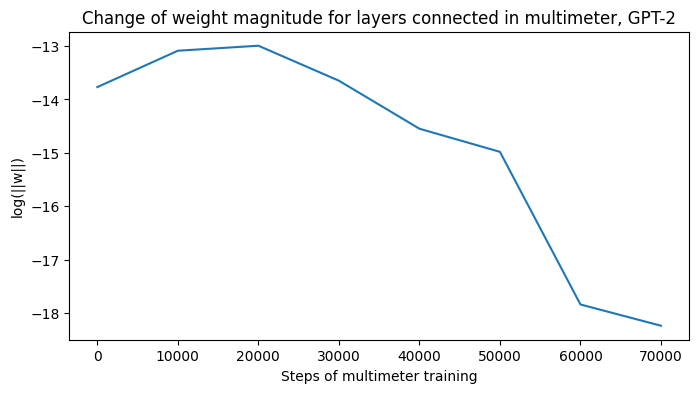

In [62]:
plt.figure(figsize = (8, 4))
plt.plot(multimeter_steps, np.log(weight_mag))
plt.ylabel('log(||w||)')
plt.xlabel('Steps of multimeter training')
plt.title('Change of weight magnitude for layers connected in multimeter, GPT-2')
plt.savefig('../figures/gpt2_postag_layer3_wmag.pdf', format = 'pdf')

## Parameter Analysis

In [63]:
multimeter_parm_paths = [os.path.join(multimeter_base, f'checkpoint-{i+1}0000') for i in range(4)]
param_vals = [0.172991092321021]
for path in multimeter_parm_paths:
    param = get_param(path)
    param_vals.append(param.detach().cpu().item())
param_vals

[0.172991092321021,
 0.6657774448394775,
 0.6657774448394775,
 0.6657774448394775,
 0.6657774448394775]

In [64]:
param_vals += [0.6657774448394775]*3

[0.172991092321021, 0.6657774448394775, 0.6657774448394775, 0.6657774448394775, 0.6657774448394775, 0.6657774448394775, 0.6657774448394775, 0.6657774448394775]
[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000]


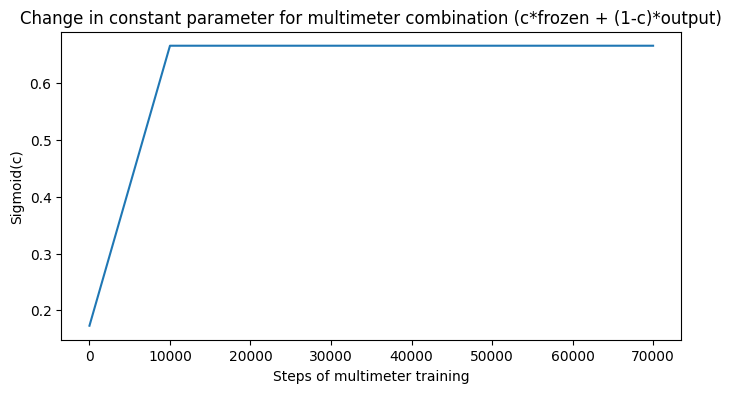

In [65]:
print(param_vals)
plt.figure(figsize = (8, 4))
print(multimeter_steps)
plt.plot(multimeter_steps, param_vals)
plt.ylabel('Sigmoid(c)')
plt.xlabel('Steps of multimeter training')
plt.title('Change in constant parameter for multimeter combination (c*frozen + (1-c)*output)')
plt.savefig('../figures/gpt2_postag_layer5_param.pdf', format = 'pdf')